In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/TAB_Betting_Data.csv')

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'])

df.fillna(0, inplace=True)

daily_df = df.groupby('DATE_DIM').agg({
    'TOTAL_TURNOVER': 'sum',
    'FOB_RACING_TURNOVER': 'sum',
    'FOB_SPORT_TURNOVER': 'sum',
    'PARI_RACING_TURNOVER': 'sum',
    'PARI_SPORT_TURNOVER': 'sum',
}).reset_index()

print(daily_df)

      DATE_DIM  TOTAL_TURNOVER  FOB_RACING_TURNOVER  FOB_SPORT_TURNOVER  \
0   2021-01-01      3835763.01           1740348.55           160299.45   
1   2021-01-02      6165935.03           3329808.95           257613.55   
2   2021-01-03      2198013.19            930629.79           331455.71   
3   2021-01-04      1523612.17            586816.57           321698.43   
4   2021-01-05      1480832.82            602373.79           224912.71   
..         ...             ...                  ...                 ...   
725 2022-12-27      2413850.20           1144594.00           311997.79   
726 2022-12-28      3379823.57           1741946.50           259758.31   
727 2022-12-29      2862803.99           1491770.50           284268.77   
728 2022-12-30      3000204.42           1543413.50           304666.43   
729 2022-12-31      5807930.20           3503842.50           367773.25   

     PARI_RACING_TURNOVER  PARI_SPORT_TURNOVER  
0              1935115.01                  0.0  
1

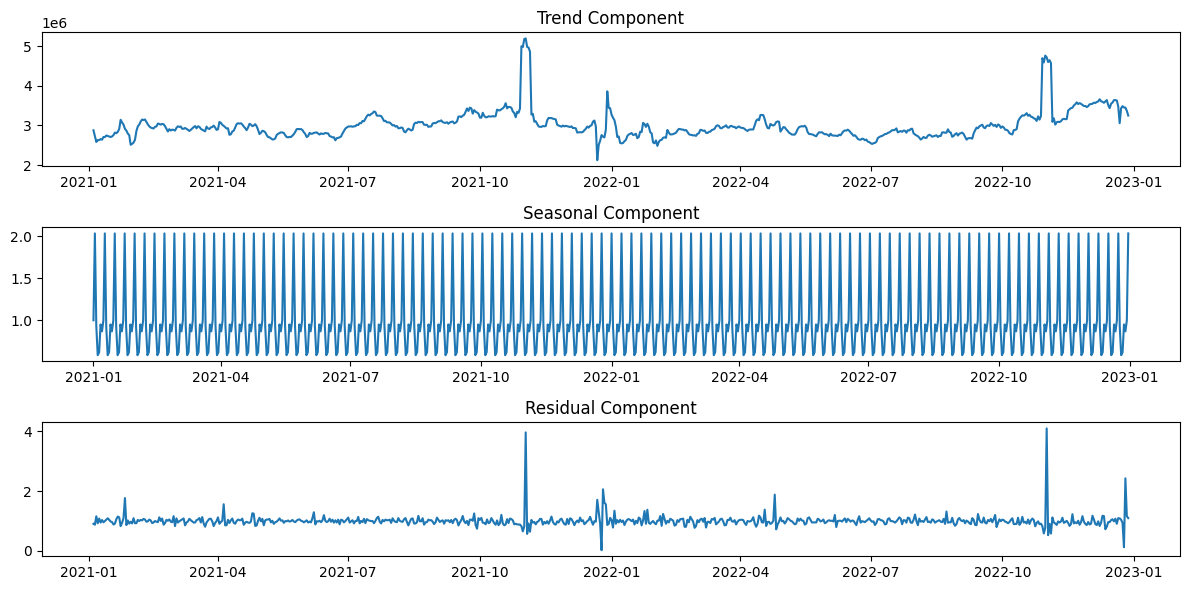

In [31]:

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'daily_df' is your DataFrame and already loaded.
df = daily_df
df.reset_index(inplace=True)

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'])
df.set_index('DATE_DIM', inplace=True)

# Apply seasonal decomposition.
# Note: You might need to adjust the 'period' parameter based on your data's seasonality.
result = seasonal_decompose(df['TOTAL_TURNOVER'], model='multiplicative', period=7)  # Example with a yearly period.
1
# Plotting the components.
plt.figure(figsize=(12, 6))

# Trend component
plt.subplot(311)
plt.plot(result.trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(312)
plt.plot(result.seasonal)
plt.title('Seasonal Component')

# Residual component
plt.subplot(313)
plt.plot(result.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [32]:
# LSTM neural networks
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import numpy as np
df = daily_df
df.reset_index(inplace=True)

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'])
df.set_index('DATE_DIM', inplace=True)

#Set period = 1 vì không cần tách time series thành các components, do LSTM có thể đọc, ghi nhớ và nhận biết trend lẫn seasonal
result = seasonal_decompose(df['TOTAL_TURNOVER'], model='multiplicative', period=1)
trend = result.trend.dropna()

# Data preparation with MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
trend_scaled = scaler.fit_transform(trend.values.reshape(-1, 1))

def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

seq_length = 14
x, y = sliding_windows(trend_scaled, seq_length)

# Adjusting train/test split to allocate 20% of the data for testing
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# LSTM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

# LSTM model parameters and training
num_epochs = 300 # Có thể chỉnh cao hơn để chính xác hơn, nhưng cực kỳ tốn thời gian training
learning_rate = 0.01

input_size = 1
hidden_size = 200
num_layers = 1
num_classes = 1

# Instantiate the LSTM model with 2 layers
lstm = LSTM(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.5f}")


Epoch: 0, loss: 0.31696
Epoch: 10, loss: 0.22770
Epoch: 20, loss: 0.07518
Epoch: 30, loss: 0.05806
Epoch: 40, loss: 0.05204
Epoch: 50, loss: 0.04304
Epoch: 60, loss: 0.02889
Epoch: 70, loss: 0.01573
Epoch: 80, loss: 0.01602
Epoch: 90, loss: 0.01457
Epoch: 100, loss: 0.01400
Epoch: 110, loss: 0.01342
Epoch: 120, loss: 0.01298
Epoch: 130, loss: 0.01255
Epoch: 140, loss: 0.02300
Epoch: 150, loss: 0.01404
Epoch: 160, loss: 0.01293
Epoch: 170, loss: 0.01231
Epoch: 180, loss: 0.01156
Epoch: 190, loss: 0.01118
Epoch: 200, loss: 0.01098
Epoch: 210, loss: 0.01090
Epoch: 220, loss: 0.01083
Epoch: 230, loss: 0.01079
Epoch: 240, loss: 0.01074
Epoch: 250, loss: 0.01069
Epoch: 260, loss: 0.01064
Epoch: 270, loss: 0.01058
Epoch: 280, loss: 0.01052
Epoch: 290, loss: 0.01047


RMSE on Test Dataset of LSTM: 1011808.56


<ipython-input-34-268c7affa112>:31: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, closed='right')


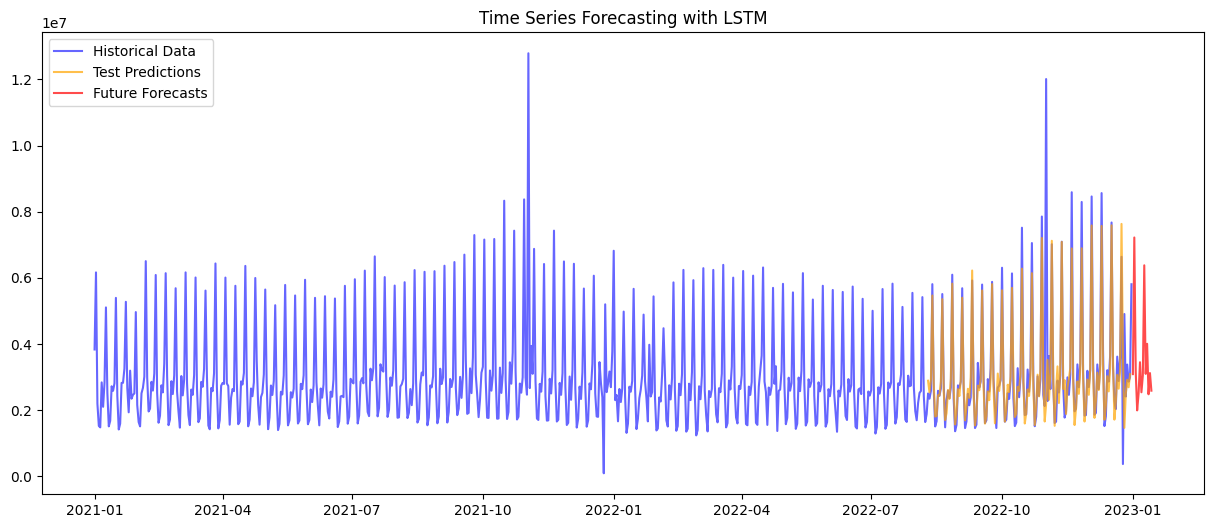

In [34]:
# Function for future forecasting
def forecast(model, input_seq, future_steps):
    model.eval()
    current_seq = input_seq
    predictions = []
    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(current_seq)
            predictions.append(pred.cpu().numpy().flatten()[0])
            current_seq = torch.cat((current_seq[:, 1:, :], pred[:, None]), dim=1)
    return predictions

testPredict = lstm(testX)
testPredict = scaler.inverse_transform(testPredict.detach().numpy())

# Forecast future values
future_steps = 14
last_seq = testX[-1:]
future_predictions_scaled = forecast(lstm, last_seq, future_steps)
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
testY_actual = scaler.inverse_transform(testY.detach().numpy())
rmse = np.sqrt(mean_squared_error(testY_actual, testPredict))
print("RMSE on Test Dataset of LSTM:", rmse)

# Visualization
plt.figure(figsize=(15,6))
plt.plot(df.index, df['TOTAL_TURNOVER'], label='Historical Data', color='blue', alpha=0.6)
test_start_date = df.index[train_size + seq_length]
test_dates = pd.date_range(start=test_start_date, periods=len(testPredict), freq='D')
plt.plot(test_dates, testPredict, label='Test Predictions', color='orange', alpha=0.7)
forecast_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, closed='right')
plt.plot(forecast_dates, future_predictions, label='Future Forecasts', color='red', alpha=0.7)
plt.legend()
plt.title('Time Series Forecasting with LSTM')
plt.show()

In [18]:
# CNN-LSTM neural networks
df = daily_df
df.reset_index(inplace=True)
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'])
df.set_index('DATE_DIM', inplace=True)

#Set period = 1 vì không cần tách time series thành các components, do LSTM có thể đọc, ghi nhớ và nhận biết trend lẫn seasonal
result = seasonal_decompose(df['TOTAL_TURNOVER'], model='multiplicative', period=1)

trend = result.trend.dropna()

scaler = MinMaxScaler(feature_range=(-1, 1))
trend_scaled = scaler.fit_transform(trend.values.reshape(-1, 1))

def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

seq_length = 14
x, y = sliding_windows(trend_scaled, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Adjusted model with CNN
class CNNLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(CNNLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        reduced_seq_length = self.seq_length // 4
        self.lstm = nn.LSTM(input_size=32 * reduced_seq_length, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        x = x.reshape(batch_size, 1, seq_length)
        c_out = self.cnn(x)
        c_out = c_out.reshape(batch_size, -1, 32 * (seq_length // 4))
        h_0 = Variable(torch.zeros(self.num_layers, c_out.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, c_out.size(0), self.hidden_size))
        lstm_out, _ = self.lstm(c_out, (h_0, c_0))
        last_time_step_out = lstm_out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out


num_epochs = 300
learning_rate = 0.007

input_size = 1
hidden_size = 300
num_layers = 3
num_classes = 1

# Instantiate the CNN-LSTM model
model = CNNLSTM(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, seq_length=seq_length)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with the new CNN-LSTM model
for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

Epoch: 0, loss: 0.41500
Epoch: 10, loss: 0.05165
Epoch: 20, loss: 0.03768
Epoch: 30, loss: 0.01575
Epoch: 40, loss: 0.01283
Epoch: 50, loss: 0.01089
Epoch: 60, loss: 0.01024
Epoch: 70, loss: 0.01000
Epoch: 80, loss: 0.00968
Epoch: 90, loss: 0.00942
Epoch: 100, loss: 0.00914
Epoch: 110, loss: 0.01021
Epoch: 120, loss: 0.01367
Epoch: 130, loss: 0.00905
Epoch: 140, loss: 0.00887
Epoch: 150, loss: 0.00850
Epoch: 160, loss: 0.00810
Epoch: 170, loss: 0.00768
Epoch: 180, loss: 0.00701
Epoch: 190, loss: 0.00562
Epoch: 200, loss: 0.00417
Epoch: 210, loss: 0.00507
Epoch: 220, loss: 0.00452
Epoch: 230, loss: 0.00378
Epoch: 240, loss: 0.00373
Epoch: 250, loss: 0.00355
Epoch: 260, loss: 0.00344
Epoch: 270, loss: 0.00335
Epoch: 280, loss: 0.00330
Epoch: 290, loss: 0.00369


RMSE on Test Dataset of CNN-LSTM: 1168926.0


<ipython-input-19-a9e70eb8ffb3>:37: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, closed='right')


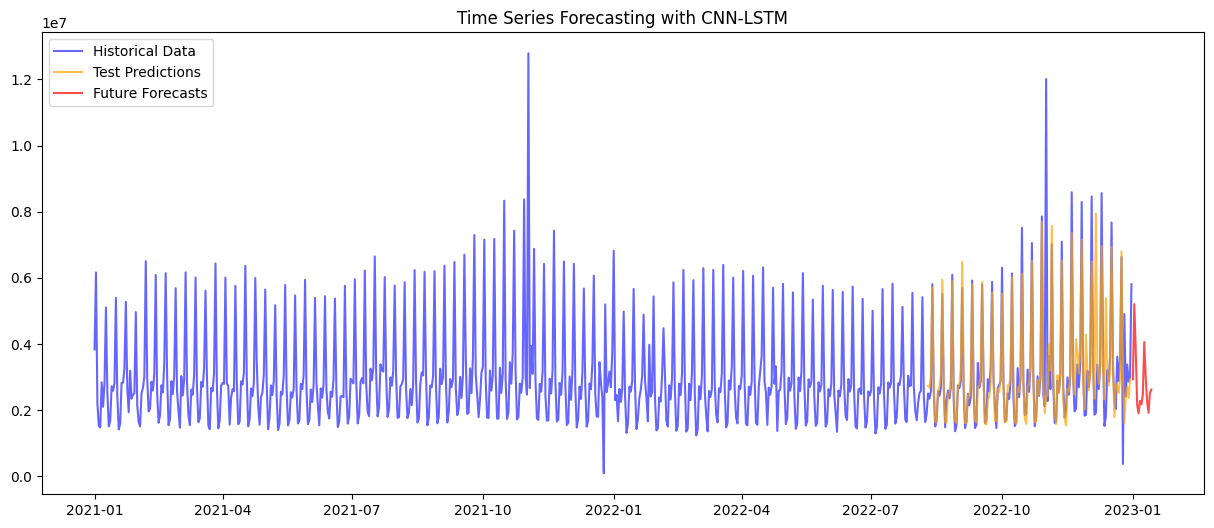

In [19]:
def forecast(model, input_seq, future_steps, seq_length):
    model.eval()
    current_seq = input_seq
    predictions = []
    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(current_seq)
            pred = pred.cpu().numpy().reshape(1, -1, 1)
            predictions.append(pred.flatten()[0])
            next_input_seq = np.concatenate((current_seq.cpu().numpy()[:, 1:, :], pred), axis=1)
            next_input_seq = torch.tensor(next_input_seq).float().to(current_seq.device)
            current_seq = next_input_seq
    return predictions

testPredict = model(testX)
testPredict = testPredict.cpu().detach().numpy()
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.detach().numpy())
rmse = np.sqrt(mean_squared_error(testY_actual, testPredict))
print("RMSE on Test Dataset of CNN-LSTM:", rmse)

future_steps = 14
last_seq = testX[-1:]
future_predictions_scaled = forecast(model, last_seq, future_steps, seq_length)
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Visualization
plt.figure(figsize=(15,6))
plt.plot(df.index, df['TOTAL_TURNOVER'], label='Historical Data', color='blue', alpha=0.6)
test_start_date = df.index[train_size + seq_length]
test_dates = pd.date_range(start=test_start_date, periods=len(testPredict), freq='D')
plt.plot(test_dates, testPredict, label='Test Predictions', color='orange', alpha=0.7)
forecast_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, closed='right')
plt.plot(forecast_dates, future_predictions, label='Future Forecasts', color='red', alpha=0.7)
plt.legend()
plt.title('Time Series Forecasting with CNN-LSTM')
plt.show()
